# Model Fine-Tuning Training


In this tutorial, you will learn how to use MindCV for transfer Learning to solve the problem of image classification on custom datasets. In the deep learning task, we often encounter the problem of insufficient training data. At this time, it is difficult to train the entire network directly to achieve the desired accuracy. A better approach is to use a pretrained model on a large dataset (close to the task data), and then use the model to initialize the network's weight parameters or apply it to specific tasks as a fixed feature extractor.

This tutorial will use the DenseNet model pretrained on ImageNet as an example to introduce two different fine-tuning strategies to solve the image classification problem of wolves and dogs in the case of small samples:

1. Overall model fine-tuning.
2. Freeze backbone and only fine tune the classifier.

> For details of transfer learning, see [Stanford University CS231n](https://cs231n.github.io/transfer-learning/#tf)

## Data Preparation

### Download Dataset

Download the [dog and wolf classification dataset](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip) used in the case. Each category has 120 training images and 30 verification images. Use the `mindcv.utils.download` interface to download the dataset, and automatically unzip the downloaded dataset to the current directory.

In [1]:
import sys
sys.path.append('../')

from mindcv.utils.download import DownLoad
import os

dataset_url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/intermediate/Canidae_data.zip"
root_dir = "./"

if not os.path.exists(os.path.join(root_dir, 'data/Canidae')):
    DownLoad().download_and_extract_archive(dataset_url, root_dir)

The directory structure of the dataset is as follows:

```Text
data/
└── Canidae
    ├── train
    │   ├── dogs
    │   └── wolves
    └── val
        ├── dogs
        └── wolves
```

## Dataset Loading and Processing


### Loading Custom Datasets

By calling the `create_dataset` function in `mindcv.data`, we can easily load preset and customized datasets.

- When the parameter `name` is set to null, it is specified as a user-defined dataset. (Default)
- When the parameter `name` is set to `MNIST`, `CIFAR10` and other standard data set names, it is specified as the preset data set.

At the same time, we need to set the path `data_dir` of the dataset and the name `split` of the data segmentation (such as train, val) to load the corresponding training set or validation set.

In [2]:
from mindcv.data import create_dataset, create_transforms, create_loader

num_workers = 8

# path of dataset
data_dir = "./data/Canidae/"

# load datset
dataset_train = create_dataset(root=data_dir, split='train', num_parallel_workers=num_workers)
dataset_val = create_dataset(root=data_dir, split='val', num_parallel_workers=num_workers)

> Note: The directory structure of the custom dataset should be the same as ImageNet, that is, the hierarchy of root ->split ->class ->image

```Text
DATASET_NAME
    ├── split1(e.g. train)/  
    │  ├── class1/
    │  │   ├── 000001.jpg
    │  │   ├── 000002.jpg
    │  │   └── ....
    │  └── class2/
    │      ├── 000001.jpg
    │      ├── 000002.jpg
    │      └── ....
    └── split2/   
       ├── class1/
       │   ├── 000001.jpg
       │   ├── 000002.jpg
       │   └── ....
       └── class2/
           ├── 000001.jpg
           ├── 000002.jpg
           └── ....
```

### Data Processing and Augmentation

First, we call the `create_transforms` function to obtain the preset data processing and augmentation strategy (transform list). In this task, because the wolf dog image and ImageNet data are consistent (that is, the domain is consistent), we specify the parameter `dataset_name` as ImageNet, and directly use the preset ImageNet data processing and image augmentation strategy. `create_transforms` also supports a variety of customized processing and enhancement operations, as well as automatic enhancement policies (AutoAug). See API description for details.

We will transfer the obtained transform list to the `create_loader()`, and specify `batch_size` and other parameters to complete the preparation of training and validation data, and return the `Dataset` Object as the input of the model.

In [3]:
# Define and acquire data processing and augment operations
trans_train = create_transforms(dataset_name='ImageNet', is_training=True)
trans_val = create_transforms(dataset_name='ImageNet',is_training=False)

# 
loader_train = create_loader(
        dataset=dataset_train,
        batch_size=16,
        is_training=True,
        num_classes=2,
        transform=trans_train,
        num_parallel_workers=num_workers,
    )
    

loader_val = create_loader(
        dataset=dataset_val,
        batch_size=5,
        is_training=True,
        num_classes=2,
        transform=trans_val,
        num_parallel_workers=num_workers,
    )

### Dataset Visualization

For the Dataset object returned by the `create_loader` interface to complete data loading, we can create a data iterator through the `create_tuple_iterator` interface, access the dataset using the `next` iteration, and read a batch of data.

In [4]:
images, labels= next(loader_train.create_tuple_iterator())
#images = data["image"]
#labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

Tensor of image (16, 3, 224, 224)
Labels: [0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1]


Visualize the acquired image and label data, and the title is the label name corresponding to the image.

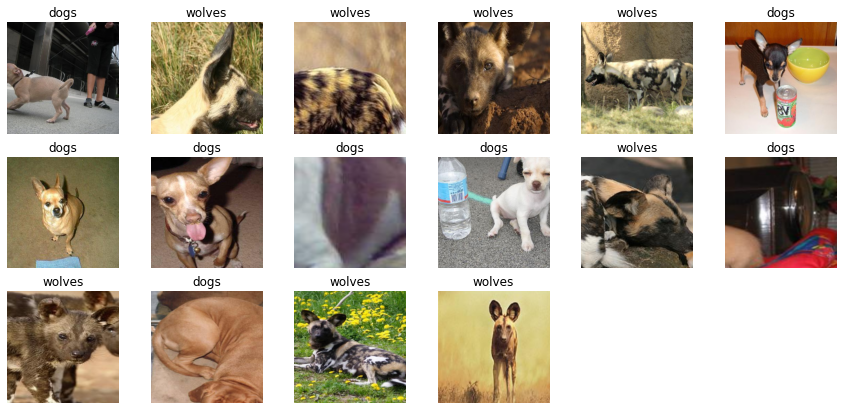

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# class_name corresponds to label, and labels are marked in the order of folder string from small to large
class_name = {0: "dogs", 1: "wolves"}

plt.figure(figsize=(15, 7))
for i in range(len(labels)):
    # Get the image and its corresponding label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    # Process images for display
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # Show Image
    plt.subplot(3, 6, i + 1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

## Model Fine-Tuning

### 1. Overall Model Fine-Tuning

#### Pretraining Model Loading
We use `mindcv.models.densenet` to define the DenseNet121 network. When the `pretrained` parameter in the interface is set to True, the network weight can be automatically downloaded. Since the pretraining model is used to classify 1000 categories in the ImageNet dataset, we set `num_classes=2`, and the output of DenseNet's classifier (the last FC layer) is adjusted to two dimensions. At this time, only the pre training weights of backbone are loaded, while the classifier uses the initial value.

In [6]:
from mindcv.models import create_model

network = create_model(model_name='densenet121', num_classes=2, pretrained=True)

[WARNING] ME(116613:140051982694208,MainProcess):2022-09-20-03:44:58.786.568 [mindspore/train/serialization.py:709] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(116613:140051982694208,MainProcess):2022-09-20-03:44:58.787.703 [mindspore/train/serialization.py:714] classifier.weight is not loaded.
[WARNING] ME(116613:140051982694208,MainProcess):2022-09-20-03:44:58.788.408 [mindspore/train/serialization.py:714] classifier.bias is not loaded.



>For the specific structure of DenseNet, see the [DenseNet paper](https://arxiv.org/pdf/1608.06993.pdf). 

#### Model Training
Use the loaded and processed wolf and dog images with tags to fine-tune the DenseNet network. Note that smaller learning rates should be used when fine-tuning the overall model.


In [7]:
from mindcv.loss import create_loss
from mindcv.optim import create_optimizer
from mindcv.scheduler import create_scheduler
from mindspore import Model, LossMonitor, TimeMonitor #, CheckpointConfig, ModelCheckpoint


# Define optimizer and loss function
opt = create_optimizer(network.trainable_params(), opt='adam', lr=1e-4) 
loss = create_loss(name='CE')

# Instantiated model
model = Model(network, loss_fn=loss, optimizer=opt, metrics={'accuracy'}) 

In [8]:
model.train(10, loader_train, callbacks=[LossMonitor(5), TimeMonitor(5)], dataset_sink_mode=False)

epoch: 1 step: 5, loss is 0.5195528864860535
epoch: 1 step: 10, loss is 0.2654373049736023
epoch: 1 step: 15, loss is 0.28758567571640015
Train epoch time: 17270.144 ms, per step time: 1151.343 ms
epoch: 2 step: 5, loss is 0.1807008981704712
epoch: 2 step: 10, loss is 0.1700802594423294
epoch: 2 step: 15, loss is 0.09752683341503143
Train epoch time: 1372.549 ms, per step time: 91.503 ms
epoch: 3 step: 5, loss is 0.13594701886177063
epoch: 3 step: 10, loss is 0.03628234937787056
epoch: 3 step: 15, loss is 0.039737217128276825
Train epoch time: 1453.237 ms, per step time: 96.882 ms
epoch: 4 step: 5, loss is 0.014213413000106812
epoch: 4 step: 10, loss is 0.030747078359127045
epoch: 4 step: 15, loss is 0.0798817127943039
Train epoch time: 1331.237 ms, per step time: 88.749 ms
epoch: 5 step: 5, loss is 0.009510636329650879
epoch: 5 step: 10, loss is 0.02603740245103836
epoch: 5 step: 15, loss is 0.051846928894519806
Train epoch time: 1312.737 ms, per step time: 87.516 ms
epoch: 6 step: 5,

#### Model Evaluation

After the training, we evaluate the accuracy of the model on the validation set.

In [9]:
res = model.eval(loader_val)
print(res)

{'accuracy': 1.0}


##### Visual Model Inference Results
Define `visualize_mode` function and visualize model prediction.

In [10]:
import matplotlib.pyplot as plt
import mindspore as ms

def visualize_model(model, val_dl, num_classes=2):
    # Load the data of the validation set for validation
    images, labels= next(val_dl.create_tuple_iterator())
    # Predict image class
    output = model.predict(images)
    pred = np.argmax(output.asnumpy(), axis=1)
    # Display images and their predicted values
    images = images.asnumpy()
    labels = labels.asnumpy()
    class_name = {0: "dogs", 1: "wolves"}
    plt.figure(figsize=(15, 7))
    for i in range(len(labels)):
        plt.subplot(3, 6, i + 1)
        # If the prediction is correct, it is displayed in blue; If the prediction is wrong, it is displayed in red
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

Use the finely tuned model piece to predict the wolf and dog image data of the verification set. If the prediction font is blue, the prediction is correct; if the prediction font is red, the prediction is wrong.

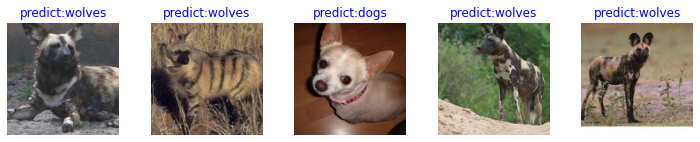

In [11]:
visualize_model(model, loader_val)

### 2. Freeze Backbone and Fine-Tune the Classifier

#### Freezing Backbone Parameters

First, we need to freeze all network layers except the last layer classifier, that is, set the `requires_grad` attribute of the corresponding layer parameter to False, so that it does not calculate the gradient and update the parameters in the back propagation.

Because all models in `mindcv.models` use a `classifier` to identify and name the classifier of the model (i.e., the Dense layer), the parameters of each layer outside the classifier can be filtered through `classifier.weight` and `classifier.bias`, and its `requires_grad` attribute is set to False.

In [12]:
# freeze backbone
for param in network.get_parameters():
    if param.name not in ["classifier.weight", "classifier.bias"]:
        param.requires_grad = False

#### Fine-Tune Classifier

Because the feature network has been fixed, we don't have to worry about distortpratised features in the training process. Therefore, compared with the first method, we can increase the learning rate.

Compared with no pretraining model, it will save more than half of the time, because partial gradient can not be calculated at this time.

In [13]:
# dataset load
dataset_train = create_dataset(root=data_dir, split='train', num_parallel_workers=num_workers)
loader_train = create_loader(
        dataset=dataset_train,
        batch_size=16,
        is_training=True,
        num_classes=2,
        transform=trans_train,
        num_parallel_workers=num_workers,
    )

# Define optimizer and loss function
opt = create_optimizer(network.trainable_params(), opt='adam', lr=1e-3) 
loss = create_loss(name='CE')

# Instantiated model
model = Model(network, loss_fn=loss, optimizer=opt, metrics={'accuracy'}) 

model.train(10, loader_train, callbacks=[LossMonitor(5), TimeMonitor(5)], dataset_sink_mode=False)

epoch: 1 step: 5, loss is 0.051333948969841
epoch: 1 step: 10, loss is 0.02043312042951584
epoch: 1 step: 15, loss is 0.16161368787288666
Train epoch time: 10228.601 ms, per step time: 681.907 ms
epoch: 2 step: 5, loss is 0.002121545374393463
epoch: 2 step: 10, loss is 0.0009798109531402588
epoch: 2 step: 15, loss is 0.015776708722114563
Train epoch time: 562.543 ms, per step time: 37.503 ms
epoch: 3 step: 5, loss is 0.008056879043579102
epoch: 3 step: 10, loss is 0.0009347647428512573
epoch: 3 step: 15, loss is 0.028648357838392258
Train epoch time: 523.249 ms, per step time: 34.883 ms
epoch: 4 step: 5, loss is 0.001014217734336853
epoch: 4 step: 10, loss is 0.0003159046173095703
epoch: 4 step: 15, loss is 0.0007699579000473022
Train epoch time: 508.886 ms, per step time: 33.926 ms
epoch: 5 step: 5, loss is 0.0015687644481658936
epoch: 5 step: 10, loss is 0.012090332806110382
epoch: 5 step: 15, loss is 0.004598274827003479
Train epoch time: 507.243 ms, per step time: 33.816 ms
epoch: 

In [14]:
dataset_val = create_dataset(root=data_dir, split='val', num_parallel_workers=num_workers)
loader_val = create_loader(
        dataset=dataset_val,
        batch_size=5,
        is_training=True,
        num_classes=2,
        transform=trans_val,
        num_parallel_workers=num_workers,
    )

res = model.eval(loader_val)
print(res)

{'accuracy': 1.0}


##### Visual Model Prediction

Use the finely tuned model piece to predict the wolf and dog image data of the verification set. If the prediction font is blue, the prediction is correct; if the prediction font is red, the prediction is wrong.

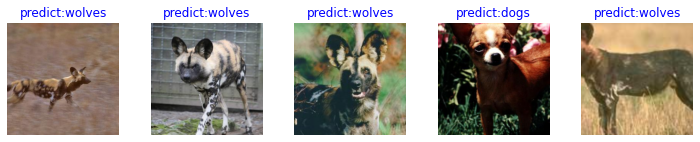

In [15]:
visualize_model(model, loader_val)

The prediction results of wolf dog after fine-tuning are correct.